In [1]:
import os, cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from collections import defaultdict, namedtuple
from tqdm import tqdm
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications import xception, vgg19
from tensorflow.keras.applications import Xception, vgg19
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, GlobalAveragePooling2D, Activation, Dense, Dropout 
from tensorflow.keras.layers import BatchNormalization, Conv2D, Embedding, MaxPool2D, SeparableConv2D, MaxPooling2D, concatenate, UpSampling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications import Xception,resnet 
from tensorflow.keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import *
from keras.optimizers import Adam, SGD, Adamax
from tensorflow.keras.optimizers import Adam
from keras.layers import Concatenate
from keras.utils.np_utils import to_categorical 

from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy



# gpu 사용가능 확인

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2041328609309861702
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6298796032
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3232796425638624492
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:08:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


# 필요한 만큼 메모리를 런타임에 할당하는 방법

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)     


1 Physical GPUs, 1 Logical GPUs


# warnings hide

In [4]:
import warnings
# 경고 메시지를 무시하고 숨기거나
warnings.filterwarnings(action='ignore')

In [5]:
SEED = 42
seed = 42
EPOCHS = 100
epochs = 100
BATCH_SIZE = 32
batch_size = 32
IMG_HEIGHT = 224
img_height = 224
IMG_WIDTH = 224
img_width = 224
num_classes = 8
patience = 5

In [6]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

In [7]:
seed_everything(seed)

In [8]:
full_df = pd.read_csv('full_df(agumentation).csv', index_col= 0)

In [9]:
full_df['labels'] = full_df['labels'].map({'N' : 0, 'D' : 1, 'G' : 2, 'C' : 3,  'A' : 4, 'H' : 5, 'M' : 6, 'O' : 7})

In [10]:
full_df['labels'].value_counts()

0    2873
4    2128
7    2124
3    2051
1    2008
2    1988
6    1856
5    1280
Name: labels, dtype: int64

In [11]:
full_df['labels'].value_counts().sum()

16308

In [12]:
df = full_df

In [13]:
df

,filename,labels
10086,preprocessed_images(divide)/M/M_270_1621_right...,6
1176,preprocessed_images(divide)/A/A_blur_1877_left...,4
13744,preprocessed_images(divide)/N/4057_left.jpg,0
12015,preprocessed_images(divide)/N/2564_left.jpg,0
8754,preprocessed_images(divide)/H/H_90_fliplr_4214...,5
...,...,...
8342,preprocessed_images(divide)/H/H_180_23_left.jpg,5
1683,preprocessed_images(divide)/A/A_fliplr_1846_ri...,4
8204,preprocessed_images(divide)/H/2004_right.jpg,5
7735,preprocessed_images(divide)/G/G_fliplr_1307_le...,2


# 데이터

In [14]:
def create_datasets(df, img_width, img_height):
    imgs = []
    for path in tqdm(df['filename']):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_width, img_height))
        imgs.append(img)
        
    imgs = np.array(imgs, dtype='float32')
#   df = pd.get_dummies(df['labels'])
    df = to_categorical(df['labels'], num_classes = 8)
    return imgs, df

In [15]:
# train data, test data 분리
train_df, test_df = train_test_split(df,
                                     test_size=0.30, 
                                     random_state=42,
                                     stratify=df['labels']
                                    )

train_df, val_df = train_test_split(train_df,
                                    test_size=0.20,
                                    random_state=42,
#                                    stratify=train_df['labels']
                                   )

In [16]:
train_df.shape, test_df.shape, val_df.shape

((9132, 2), (4893, 2), (2283, 2))

In [17]:
train_imgs, train_labels = create_datasets(train_df, IMG_WIDTH, IMG_HEIGHT)
val_imgs, val_labels = create_datasets(val_df, IMG_WIDTH, IMG_HEIGHT)
test_imgs, test_labels = create_datasets(test_df, IMG_WIDTH, IMG_HEIGHT)

100%|██████████| 4893/4893 [00:17<00:00, 275.35it/s]


In [18]:
train_imgs = train_imgs / 255.0
val_imgs = val_imgs / 255.0
test_imgs = test_imgs / 255.0


In [19]:
'''
train_imgs = preprocess_input(train_imgs)
val_imgs = preprocess_input(val_imgs)
test_imgs = preprocess_input(test_imgs)
'''

'\ntrain_imgs = preprocess_input(train_imgs)\nval_imgs = preprocess_input(val_imgs)\ntest_imgs = preprocess_input(test_imgs)\n'

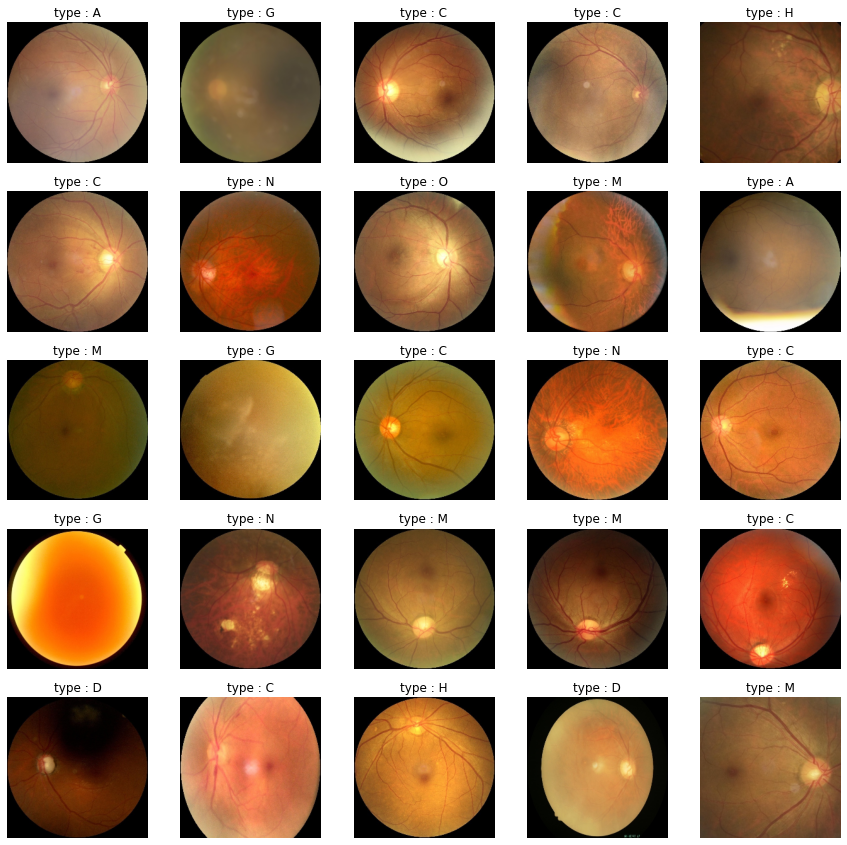

In [20]:
f, ax = plt.subplots(5, 5, figsize=(15,15))
for i, img in enumerate(train_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if train_labels[i,0] == 1:
        ax[i//5, i%5].set_title('type : A')
    elif train_labels[i,1] == 1:
        ax[i//5, i%5].set_title('type : C')
    elif train_labels[i,2] == 1:
        ax[i//5, i%5].set_title('type : D')
    elif train_labels[i,3] == 1:
        ax[i//5, i%5].set_title('type : G')
    elif train_labels[i,4] == 1:
        ax[i//5, i%5].set_title('type : H')
    elif train_labels[i,5] == 1:
        ax[i//5, i%5].set_title('type : M')
    elif train_labels[i,6] == 1:
        ax[i//5, i%5].set_title('type : N')
    else:
        ax[i//5, i%5].set_title('type : O')
plt.show()


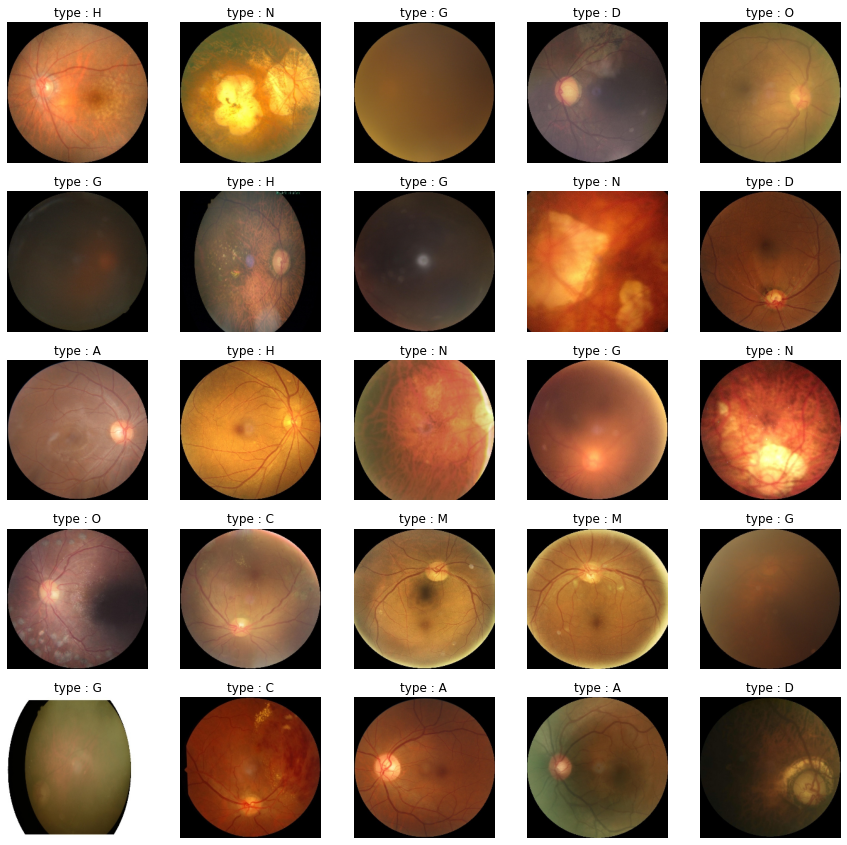

In [21]:
f, ax = plt.subplots(5, 5, figsize=(15,15))
for i, img in enumerate(test_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if test_labels[i,0] == 1:
        ax[i//5, i%5].set_title('type : A')
    elif test_labels[i,1] == 1:
        ax[i//5, i%5].set_title('type : C')
    elif test_labels[i,2] == 1:
        ax[i//5, i%5].set_title('type : D')
    elif test_labels[i,3] == 1:
        ax[i//5, i%5].set_title('type : G')
    elif test_labels[i,4] == 1:
        ax[i//5, i%5].set_title('type : H')
    elif test_labels[i,5] == 1:
        ax[i//5, i%5].set_title('type : M')
    elif test_labels[i,6] == 1:
        ax[i//5, i%5].set_title('type : N')
    else:
        ax[i//5, i%5].set_title('type : O')
plt.show()


In [22]:
len(train_imgs), len(val_imgs), len(test_imgs)

(9132, 2283, 4893)

In [23]:
train_imgs.shape, val_imgs.shape, test_imgs.shape

((9132, 224, 224, 3), (2283, 224, 224, 3), (4893, 224, 224, 3))

In [24]:
train_labels.shape, val_labels.shape, test_labels.shape

((9132, 8), (2283, 8), (4893, 8))

# Model

In [ ]:
del res_net

In [ ]:
BinaryAccuracy = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc')
]


In [56]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    res = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
)
    
    
    x = res(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(8, activation='sigmoid')(x)
    res_net = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.01)
    res_net.compile(optimizer=opt, loss=loss, metrics=[BinaryAccuracy])
    return res_net

res_net = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
res_net.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_6   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 8)                 16392     
                                                                 
Total params: 23,604,104
Trainable params: 23,550,984
Non-trainable params: 53,120
_________________________________________________________________


In [57]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.1,
                               fill_mode='reflect') 

es_callback = tf.keras.callbacks.EarlyStopping(patience=20, 
                                               verbose=1, 
                                               restore_best_weights=True)


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

Epoch 1/100
285/285 [==============================] - 83s 275ms/step - loss: 0.5285 - accuracy: 0.7507 - precision: 0.2026 - recall: 0.3387 - auc: 0.6372 - val_loss: 0.5941 - val_accuracy: 0.6199 - val_precision: 0.1093 - val_recall: 0.2856 - val_auc: 0.4823 - lr: 3.0000e-06
Epoch 2/100
285/285 [==============================] - 78s 272ms/step - loss: 0.3100 - accuracy: 0.8947 - precision: 0.7975 - recall: 0.2113 - auc: 0.8201 - val_loss: 0.6140 - val_accuracy: 0.6936 - val_precision: 0.1571 - val_recall: 0.3325 - val_auc: 0.5427 - lr: 3.0000e-06
Epoch 3/100
285/285 [==============================] - 79s 275ms/step - loss: 0.2680 - accuracy: 0.9031 - precision: 0.8330 - recall: 0.2813 - auc: 0.8802 - val_loss: 0.3939 - val_accuracy: 0.8533 - val_precision: 0.3569 - val_recall: 0.2168 - val_auc: 0.7256 - lr: 3.0000e-06
Epoch 4/100
285/285 [==============================] - 78s 273ms/step - loss: 0.2453 - accuracy: 0.9092 - precision: 0.8276 - recall: 0.3454 - auc: 0.9079 - val_loss: 0.

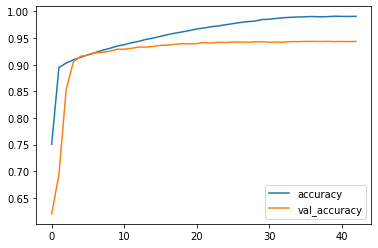

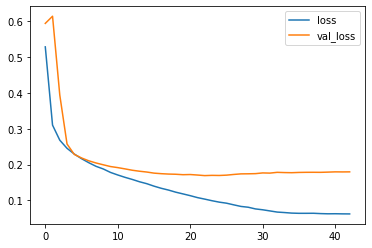

In [58]:
history = res_net.fit(generator.flow(train_imgs, 
                                   train_labels,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_labels))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [148]:
#res_net.save('resnet50_2.h5')

In [25]:
load_model = tf.keras.models.load_model('resnet50_2.h5')

In [26]:
load_model.evaluate(test_imgs, test_labels)

153/153 [==============================] - 16s 73ms/step - loss: 0.1690 - accuracy: 0.9405 - precision: 0.7936 - recall: 0.7082 - auc: 0.9643


[0.16904525458812714,
 0.9405017495155334,
 0.7936326265335083,
 0.7081544995307922,
 0.9642646312713623]

In [27]:
test_df['labels'] = test_df['labels'].map({0 : 'N', 1 : 'D', 2 : 'G', 3 : 'C',  4 : 'A' , 5 : 'H' , 6 : 'M' , 7 : 'O' })

In [28]:
test_df

,filename,labels
171,preprocessed_images(divide)/A/334_left.jpg,A
10961,preprocessed_images(divide)/M/M_fliplr_1584_le...,M
2362,preprocessed_images(divide)/C/2233_left.jpg,C
6464,preprocessed_images(divide)/G/583_left.jpg,G
15389,preprocessed_images(divide)/O/O_180_676_left.jpg,O
...,...,...
4979,preprocessed_images(divide)/D/4326_left.jpg,D
12518,preprocessed_images(divide)/N/2832_right.jpg,N
8917,preprocessed_images(divide)/H/H_90_flipud_723_...,H
6883,preprocessed_images(divide)/G/G_270_1307_left.jpg,G


In [41]:
def cg(xx):
    lis = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
    return lis[xx - 1]

In [42]:
for iii in range(0, 25):
    print(test_df['filename'][iii : iii + 1].values)
    aaa = load_model.predict(test_imgs[iii:iii+1])
    bbb = aaa[0] * 100
    ccc = bbb.astype(int)
    
    
    
    #print("Label :" , test_labels[iii,:],  '=>',   test_labels[iii,:].argmax() + 1 )
    print("Label :" , test_labels[iii,:],  '=>',  test_df['labels'][iii : iii + 1].values )
    xx = ccc.argmax() + 1
    print("Predict :" , ccc, '=>', [cg(xx)])
    if test_df['labels'][iii : iii + 1].values == [cg(xx)]:
        print('True')
    else :
        print('False')
    print()

['preprocessed_images(divide)/A/334_left.jpg']
1/1 [==============================] - 0s 21ms/step
Label : [0. 0. 0. 0. 1. 0. 0. 0.] => ['A']
Predict : [ 1  0  0  0 98  0  0  0] => ['A']
True

['preprocessed_images(divide)/M/M_fliplr_1584_left.jpg']
1/1 [==============================] - 0s 19ms/step
Label : [0. 0. 0. 0. 0. 0. 1. 0.] => ['M']
Predict : [ 0  1  0  0  0  0 98  0] => ['M']
True

['preprocessed_images(divide)/C/2233_left.jpg']
1/1 [==============================] - 0s 20ms/step
Label : [0. 0. 0. 1. 0. 0. 0. 0.] => ['C']
Predict : [ 0  1  1 98  0  1  0  1] => ['C']
True

['preprocessed_images(divide)/G/583_left.jpg']
1/1 [==============================] - 0s 20ms/step
Label : [0. 0. 1. 0. 0. 0. 0. 0.] => ['G']
Predict : [ 0  4 99  0  0  0  0  0] => ['G']
True

['preprocessed_images(divide)/O/O_180_676_left.jpg']
1/1 [==============================] - 0s 19ms/step
Label : [0. 0. 0. 0. 0. 0. 0. 1.] => ['O']
Predict : [ 0  6  0  7  0  1  0 99] => ['O']
True

['preprocessed_ima